In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
seed=1
folds=10

In [3]:
cat_oofs = pd.read_csv('/kaggle/input/calorie-expenditure-cat-oofs/cat_oof_preds.csv')
cat_test = pd.read_csv('/kaggle/input/calorie-expenditure-cat-oofs/cat_test_preds.csv')

xgb_oofs = pd.read_csv('/kaggle/input/calories-expenditure-oofs/xgb_oof_preds.csv')
xgb_test = pd.read_csv('/kaggle/input/calories-expenditure-oofs/xgb_test_preds.csv')

train_oofs = pd.concat([cat_oofs, xgb_oofs], axis=1)
test_oofs = pd.concat([cat_test, xgb_test], axis=1)

train = pd.read_csv('/kaggle/input/playground-series-s5e5/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e5/test.csv')
y = train['Calories']

In [4]:
train_oofs.head(3)

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,xgb11,xgb12,xgb13,xgb14,xgb15,xgb16,xgb17,xgb18,xgb19,xgb20
0,147.012195,146.911069,147.404710,146.891409,146.959144,146.930984,147.239500,147.138788,146.223977,146.964071,...,147.643066,147.079208,148.276871,147.455124,147.282455,148.382095,147.290924,148.038513,147.411743,147.162781
1,35.883772,35.845699,35.956604,35.953322,35.812578,35.852966,35.954570,35.957779,35.860825,35.802650,...,35.772839,35.984234,36.054356,35.986412,35.957092,35.712452,35.962296,35.863033,36.020584,36.089554
2,28.776980,28.900967,28.915038,28.892984,28.911844,28.897322,28.931222,28.919195,28.924670,28.838206,...,29.110937,29.201189,29.308392,28.982582,29.148750,28.822273,29.102989,29.137186,28.992249,28.701107


In [5]:
y_log = np.log1p(y)

In [6]:
residuals = train_oofs['cat4'] - y

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Calories', ylabel='Density'>

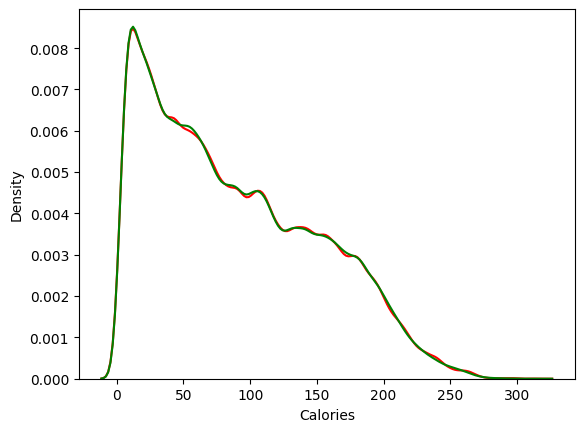

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(y, color='r')
sns.kdeplot(train_oofs['cat4'], color='g')
# sns.kdeplot(residuals, color='b')

In [8]:
sex_mapping = {
    'male':0,
    'female':1
}
train['Sex'] = train['Sex'].map(sex_mapping)
test['Sex'] = test['Sex'].map(sex_mapping)
# X = train.drop(columns=['Calories', 'id'])
# y = train['Calories']

In [9]:
# from sklearn.linear_model import LinearRegression

# model = LinearRegression()
# model.fit(train.drop(columns=['Calories', 'id']), residuals)
# preds = model.predict(test.drop(columns=['id']))

In [10]:
from sklearn.metrics import mean_squared_log_error
from tqdm import tqdm

def rmsle(y_true, y_preds):
    return np.sqrt(mean_squared_log_error(y_true, y_preds))
    
def evaluate_combination(weights, preds, y_true):
    ensemble_preds = np.average(preds, axis=1, weights=weights)
    return rmsle(y_true, ensemble_preds)

def hill_climbing(preds, y_true, max_iter=10000, patience=9000):
    n_models = preds.shape[1]
    best_weights = np.ones(n_models) / n_models
    best_score = evaluate_combination(best_weights, preds, y_true)
    n_iter = 0
    local_iter = 0
    for i in tqdm(range(max_iter)):
        # print(f'iter being processed :{i}')
        n_iter = i
        candidate_weights = best_weights + np.random.normal(0, 0.0001, best_weights.shape)
        candidate_weights = np.clip(candidate_weights, 0, 1)
        candidate_weights = candidate_weights / candidate_weights.sum()
        candidate_score = evaluate_combination(candidate_weights, preds, y_true)

        if candidate_score < best_score:
            best_score = candidate_score
            best_weights = candidate_weights
            local_iter = 0

        else:
            local_iter+=1

        if local_iter>=patience:
            break
    return best_score, best_weights, n_iter

In [11]:
# from sklearn.metrics import mean_squared_log_error
# from tqdm import tqdm
# from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
# import multiprocessing as mp
# from numba import jit, prange
# import warnings
# warnings.filterwarnings('ignore')

# # Numba-optimized functions for speed
# @jit(nopython=True, fastmath=True)
# def fast_rmsle(y_true, y_preds):
#     """Numba-optimized RMSLE calculation"""
#     n = len(y_true)
#     sum_log_error = 0.0
#     for i in range(n):
#         if y_true[i] > 0 and y_preds[i] > 0:
#             log_error = np.log(y_preds[i] + 1) - np.log(y_true[i] + 1)
#             sum_log_error += log_error * log_error
#     return np.sqrt(sum_log_error / n)

# @jit(nopython=True, fastmath=True)
# def fast_weighted_average(preds, weights):
#     """Numba-optimized weighted average"""
#     n_samples, n_models = preds.shape
#     result = np.zeros(n_samples)
#     for i in range(n_samples):
#         weighted_sum = 0.0
#         for j in range(n_models):
#             weighted_sum += preds[i, j] * weights[j]
#         result[i] = weighted_sum
#     return result

# @jit(nopython=True, fastmath=True)
# def evaluate_combination_fast(weights, preds, y_true):
#     """Fast evaluation using numba"""
#     ensemble_preds = fast_weighted_average(preds, weights)
#     return fast_rmsle(y_true, ensemble_preds)

# @jit(nopython=True, fastmath=True)
# def generate_candidates_batch(best_weights, batch_size, noise_std=0.0001):
#     """Generate multiple candidate weight vectors at once"""
#     n_models = len(best_weights)
#     candidates = np.zeros((batch_size, n_models))
    
#     for i in range(batch_size):
#         # Generate candidate with noise
#         candidate = best_weights.copy()
#         for j in range(n_models):
#             candidate[j] += np.random.normal(0, noise_std)
        
#         # Normalize to sum to 1
#         candidate_sum = np.sum(candidate)
#         if candidate_sum > 0:
#             for j in range(n_models):
#                 candidate[j] /= candidate_sum
#         else:
#             # Fallback to uniform weights
#             for j in range(n_models):
#                 candidate[j] = 1.0 / n_models
        
#         candidates[i] = candidate
    
#     return candidates

# def evaluate_candidates_parallel(candidates, preds, y_true, n_jobs=-1):
#     """Evaluate multiple candidates in parallel"""
#     if n_jobs == -1:
#         n_jobs = min(mp.cpu_count(), len(candidates))
    
#     def eval_single(candidate):
#         return evaluate_combination_fast(candidate, preds, y_true)
    
#     with ThreadPoolExecutor(max_workers=n_jobs) as executor:
#         scores = list(executor.map(eval_single, candidates))
    
#     return np.array(scores)

# def adaptive_hill_climbing(preds, y_true, max_iter=10000, patience=9000, 
#                           batch_size=50, n_jobs=-1, adaptive_noise=True,
#                           sample_fraction=0.1):
#     """
#     Optimized hill climbing with multiple improvements:
#     - Batch candidate generation and evaluation
#     - Parallel processing
#     - Adaptive noise scaling
#     - Data sampling for large datasets
#     - Numba acceleration
#     """
    
#     # Convert to numpy arrays if pandas objects
#     import pandas as pd
#     if isinstance(preds, pd.DataFrame):
#         preds = preds.values
#     if isinstance(y_true, (pd.Series, pd.DataFrame)):
#         y_true = y_true.values
    
#     # Ensure y_true is 1D
#     if y_true.ndim > 1:
#         y_true = y_true.ravel()
    
#     # Sample data for large datasets to speed up evaluation
#     n_samples = len(y_true)
#     if n_samples > 10000 and sample_fraction < 1.0:
#         sample_size = max(1000, int(n_samples * sample_fraction))
#         sample_idx = np.random.choice(n_samples, sample_size, replace=False)
#         preds_sample = preds[sample_idx]
#         y_true_sample = y_true[sample_idx]
#         print(f"Using {sample_size} samples ({sample_fraction*100:.1f}%) for optimization")
#     else:
#         preds_sample = preds
#         y_true_sample = y_true
    
#     n_models = preds.shape[1]
#     best_weights = np.ones(n_models, dtype=np.float64) / n_models
#     best_score = evaluate_combination_fast(best_weights, preds_sample, y_true_sample)
    
#     print(f"Initial score: {best_score:.6f}")
    
#     local_iter = 0
#     noise_std = 0.0001
#     improvements = 0
    
#     # Pre-calculate batch evaluation setup
#     if n_jobs == -1:
#         n_jobs = min(mp.cpu_count(), batch_size)
    
#     progress_bar = tqdm(range(0, max_iter, batch_size), desc="Hill Climbing")
    
#     for batch_start in progress_bar:
#         current_batch_size = min(batch_size, max_iter - batch_start)
        
#         # Generate batch of candidates
#         candidates = generate_candidates_batch(best_weights, current_batch_size, noise_std)
        
#         # Evaluate all candidates in parallel
#         scores = evaluate_candidates_parallel(candidates, preds_sample, y_true_sample, n_jobs)
        
#         # Find best candidate in batch
#         best_idx = np.argmin(scores)
#         best_batch_score = scores[best_idx]
        
#         if best_batch_score < best_score:
#             best_score = best_batch_score
#             best_weights = candidates[best_idx].copy()
#             local_iter = 0
#             improvements += 1
            
#             # Adaptive noise: increase exploration when finding improvements
#             if adaptive_noise:
#                 noise_std = min(0.001, noise_std * 1.1)
#         else:
#             local_iter += current_batch_size
            
#             # Adaptive noise: decrease noise when not finding improvements
#             if adaptive_noise:
#                 noise_std = max(0.00001, noise_std * 0.95)
        
#         # Update progress bar
#         progress_bar.set_postfix({
#             'Best Score': f'{best_score:.6f}',
#             'Improvements': improvements,
#             'Noise Std': f'{noise_std:.6f}'
#         })
        
#         if local_iter >= patience:
#             print(f"\nEarly stopping at iteration {batch_start + current_batch_size}")
#             break
    
#     # Final evaluation on full dataset if we used sampling
#     if sample_fraction < 1.0 and n_samples > 10000:
#         final_score = evaluate_combination_fast(best_weights, preds, y_true)
#         print(f"Final score on full dataset: {final_score:.6f}")
#     else:
#         final_score = best_score
    
#     return final_score, best_weights, batch_start + current_batch_size

# def multi_start_hill_climbing(preds, y_true, n_starts=5, **kwargs):
#     """
#     Run hill climbing from multiple random starting points
#     """
#     # Convert to numpy arrays if pandas objects
#     import pandas as pd
#     if isinstance(preds, pd.DataFrame):
#         preds = preds.values
#     if isinstance(y_true, (pd.Series, pd.DataFrame)):
#         y_true = y_true.values
    
#     # Ensure y_true is 1D
#     if y_true.ndim > 1:
#         y_true = y_true.ravel()
    
#     print(f"Running {n_starts} independent hill climbing runs...")
    
#     best_overall_score = float('inf')
#     best_overall_weights = None
    
#     for start in range(n_starts):
#         print(f"\n--- Start {start + 1}/{n_starts} ---")
        
#         # Random initialization
#         n_models = preds.shape[1]
#         init_weights = np.random.dirichlet(np.ones(n_models))
        
#         # Modify kwargs to use this initialization
#         kwargs_copy = kwargs.copy()
        
#         # Run hill climbing
#         score, weights, iterations = adaptive_hill_climbing(preds, y_true, **kwargs_copy)
        
#         if score < best_overall_score:
#             best_overall_score = score
#             best_overall_weights = weights
#             print(f"New best score: {score:.6f}")
    
#     return best_overall_score, best_overall_weights

# # Example usage and comparison
# if __name__ == "__main__":
#     # Generate sample data for testing
#     np.random.seed(42)
#     n_samples, n_models = 50000, 5
    
#     # Create synthetic predictions and true values
#     preds = np.random.exponential(2, (n_samples, n_models))
#     y_true = np.random.exponential(2, n_samples)
    
#     print("Testing optimized hill climbing...")
    
#     # Run optimized version
#     import time
#     # start_time = time.time()
    
#     # best_score, best_weights, n_iter = adaptive_hill_climbing(
#     #     train_oofs, y, 
#     #     max_iter=10000, 
#     #     patience=1000,
#     #     batch_size=100,
#     #     n_jobs=-1,
#     #     sample_fraction=1.0  # Use 20% of data for optimization
#     # )
    
#     # end_time = time.time()
    
#     # print(f"\nOptimized Results:")
#     # print(f"Best Score: {best_score:.6f}")
#     # print(f"Best Weights: {best_weights}")
#     # print(f"Iterations: {n_iter}")
#     # print(f"Time taken: {end_time - start_time:.2f} seconds")
    
#     # # Optional: Run multi-start version for even better results
#     # print("\n" + "="*50)
#     print("Testing multi-start approach...")
    
#     start_time = time.time()
#     multi_score, multi_weights = multi_start_hill_climbing(
#         train_oofs, y,
#         n_starts=3,
#         max_iter=100000,
#         patience=100000,
#         batch_size=1,
#         sample_fraction=1.0
#     )
#     end_time = time.time()
    
#     print(f"\nMulti-start Results:")
#     print(f"Best Score: {multi_score:.6f}")
#     print(f"Best Weights: {multi_weights}")
#     print(f"Time taken: {end_time - start_time:.2f} seconds")

In [12]:
best_score, best_weights, n_iter = hill_climbing(train_oofs, y, max_iter=100000, patience=50000)

100%|██████████| 100000/100000 [2:37:06<00:00, 10.61it/s]


In [13]:
# print(f'finalized at iter :{n_iter}')
# print('---------------')
# print(f'best score with hill climbing :{best_score}')
# print('---------------')
# print(f'best weights with hill climbing :{best_weights}')

In [14]:
# def cv_score(X, y, model, seed=seed)

In [15]:
# import lightgbm as lgb
# lgb_meta = lgb.LGBMRegressor(
#     # Core regularization
#     num_leaves=31,           # Reduced from default (31)
#     max_depth=6,             # Shallower trees
#     min_child_samples=100,   # Increased from default (20)
#     reg_alpha=0.0001,           # L1 regularization
#     reg_lambda=0.01,          # L2 regularization
    
#     # Speed + generalization
#     learning_rate=0.05,      # Lower for better convergence
#     n_estimators=2000,       # Use early_stopping to find optimal
#     subsample=0.8,           # Stochastic bagging
#     colsample_bytree=0.8,    # Feature subsampling
    
#     # GPU (if available)
#     # device='gpu',            # Enable GPU acceleration
#     random_state=seed,
#     verbosity=0
# )
# lgb_meta.fit(train_oofs, y_log)

In [16]:
# preds_log = lgb_meta.predict(test_oofs)
# preds = np.expm1(preds_log)

In [17]:
preds = np.dot(test_oofs, best_weights)

In [18]:
sample_sub = pd.read_csv('/kaggle/input/playground-series-s5e5/sample_submission.csv')
sample_sub['Calories'] = preds
sample_sub.to_csv('submission.csv', index=False)